## Part 1: Directory Structure and Data Loader
This part sets up the required directory structure, defines patch sizes, and loads images and masks.

In [11]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from patchify import patchify

In [12]:
# Define constants
PATCH_SIZE = 128  # Size of patches / May need to be changed to 256
DATASET_DIR = "dataset"  # Update this path to the dataset location
OUTPUT_DIR = "dataset_patched"  # Directory for storing processed patches
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [13]:
# Function to detect and crop Petri dishes from images and their masks
def detect_and_crop_petri_dish_with_masks(image_path, mask_paths):
    image = cv2.imread(image_path, 0)  # Grayscale
    original_image = cv2.imread(image_path)  # Original for cropping
    
    blurred = cv2.medianBlur(image, 5)
    _, output_im = cv2.threshold(blurred, 150, 255, cv2.THRESH_BINARY)
    
    kernel = np.ones((9, 9), np.uint8)
    im_d = cv2.dilate(output_im, kernel, iterations=3)
    im_closing = cv2.erode(im_d, kernel, iterations=4)
    
    contours, _ = cv2.findContours(im_closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    size = max(w, h)
    x_center, y_center = x + w // 2, y + h // 2
    x_start, y_start = x_center - size // 2, y_center - size // 2
    x_end, y_end = x_start + size, y_start + size
    
    cropped_image = original_image[max(0, y_start):min(image.shape[0], y_end), 
                                   max(0, x_start):min(image.shape[1], x_end)]
    cropped_masks = []
    for mask_path in mask_paths:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        cropped_mask = mask[max(0, y_start):min(mask.shape[0], y_end), 
                            max(0, x_start):min(mask.shape[1], x_end)]
        cropped_masks.append(cropped_mask)
    
    return cropped_image, cropped_masks

In [14]:
# Function to process and save patches
def create_patches_and_save(image_dir, mask_dir, output_dir, patch_size, dataset_type):
    """
    Processes images and their corresponding masks, crops them based on the Petri dish, 
    and divides them into patches, saving the results.

    Parameters:
        image_dir: Path to the images directory (train_images or val_images).
        mask_dir: Path to the masks directory (train_masks or val_masks).
        output_dir: Path where patches will be saved.
        patch_size: Size of patches.
        dataset_type: Either 'train' or 'val' to locate subdirectories.
    """
    os.makedirs(os.path.join(output_dir, f"{dataset_type}_images", dataset_type), exist_ok=True)
    os.makedirs(os.path.join(output_dir, f"{dataset_type}_masks", dataset_type), exist_ok=True)

    for image_name in os.listdir(os.path.join(image_dir, dataset_type)):
        if not image_name.endswith(".png"):
            continue

        image_path = os.path.join(image_dir, dataset_type, image_name)
        base_name = image_name[:-4]  # Remove `.png`

        # Identify corresponding masks
        mask_paths = [
            os.path.join(mask_dir, dataset_type, f"{base_name}_shoot_mask.tif"),
            os.path.join(mask_dir, dataset_type, f"{base_name}_seed_mask.tif"),
            os.path.join(mask_dir, dataset_type, f"{base_name}_root_mask.tif")
        ]

        # Filter out missing masks
        mask_paths = [path for path in mask_paths if os.path.exists(path)]

        # Crop the image and masks
        cropped_image, cropped_masks = detect_and_crop_petri_dish_with_masks(image_path, mask_paths)

        # Pad and divide into patches
        height, width = cropped_image.shape[:2]
        pad_h = (patch_size - height % patch_size) % patch_size
        pad_w = (patch_size - width % patch_size) % patch_size

        padded_image = np.pad(cropped_image, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant')
        padded_masks = [
            np.pad(mask, ((0, pad_h), (0, pad_w)), mode='constant') for mask in cropped_masks
        ]

        image_patches = patchify(padded_image, (patch_size, patch_size, 3), step=patch_size)
        mask_patches = [patchify(mask, (patch_size, patch_size), step=patch_size) for mask in padded_masks]

        for i in range(image_patches.shape[0]):
            for j in range(image_patches.shape[1]):
                image_patch = image_patches[i, j, 0]
                combined_mask_patch = np.zeros((patch_size, patch_size), dtype=np.uint8)

                for mask_patch in mask_patches:
                    if i < mask_patch.shape[0] and j < mask_patch.shape[1]:
                        combined_mask_patch = cv2.bitwise_or(combined_mask_patch, mask_patch[i, j])

                # Scale the mask to 0-255 for saving
                combined_mask_patch = (combined_mask_patch * 255).astype(np.uint8)

                patch_name = f"{base_name}_{i}_{j}.png"
                image_output_dir = os.path.join(output_dir, f"{dataset_type}_images", dataset_type)
                mask_output_dir = os.path.join(output_dir, f"{dataset_type}_masks", dataset_type)

                # Save the image and mask patches
                cv2.imwrite(os.path.join(image_output_dir, patch_name), image_patch)
                cv2.imwrite(os.path.join(mask_output_dir, patch_name), combined_mask_patch)

In [15]:
# Apply the function to train and validation datasets
create_patches_and_save(
    image_dir=os.path.join(DATASET_DIR, "train_images"),
    mask_dir=os.path.join(DATASET_DIR, "train_masks"),
    output_dir=OUTPUT_DIR,
    patch_size=PATCH_SIZE,
    dataset_type="train",
)

In [16]:
create_patches_and_save(
    image_dir=os.path.join(DATASET_DIR, "val_images"),
    mask_dir=os.path.join(DATASET_DIR, "val_masks"),
    output_dir=OUTPUT_DIR,
    patch_size=PATCH_SIZE,
    dataset_type="val",
)

## Part 2: Verification of Dataset Preparation
This part verifies that the patches were created correctly by randomly sampling patches and overlaying them.

In [17]:
# Helper function to display random patches
def display_random_patch(output_dir, dataset_type="train"):
    """
    Displays a random image patch, its corresponding mask, and the overlay for verification.
    """
    image_dir = os.path.join(output_dir, f"{dataset_type}_images", dataset_type)
    mask_dir = os.path.join(output_dir, f"{dataset_type}_masks", dataset_type)

    random_image_name = np.random.choice(os.listdir(image_dir))
    image_path = os.path.join(image_dir, random_image_name)
    mask_path = os.path.join(mask_dir, random_image_name)

    # Read the image and mask
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Create overlay
    overlay = image.copy()
    overlay[mask > 0] = [255, 0, 0]  # Highlight mask in red

    # Plot results
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Patch")
    axes[0].axis("off")

    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title("Mask Patch")
    axes[1].axis("off")

    axes[2].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    axes[2].set_title("Overlay")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

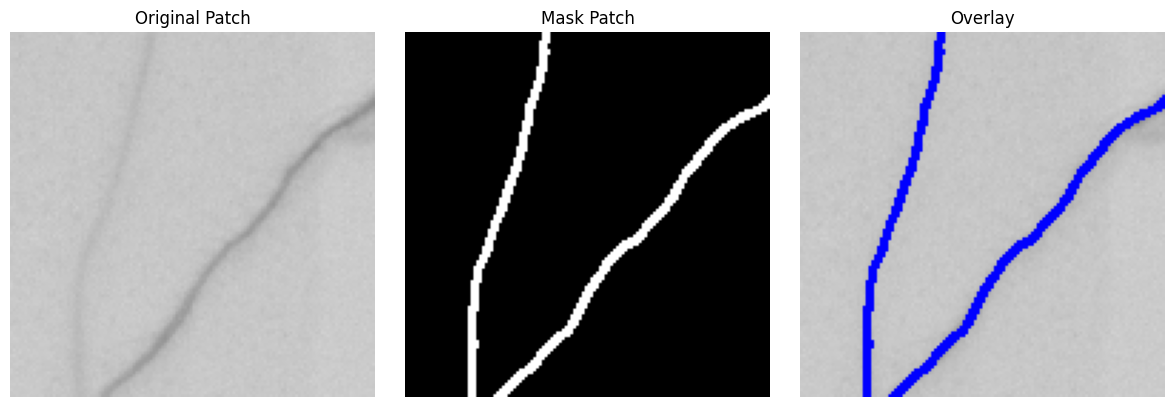

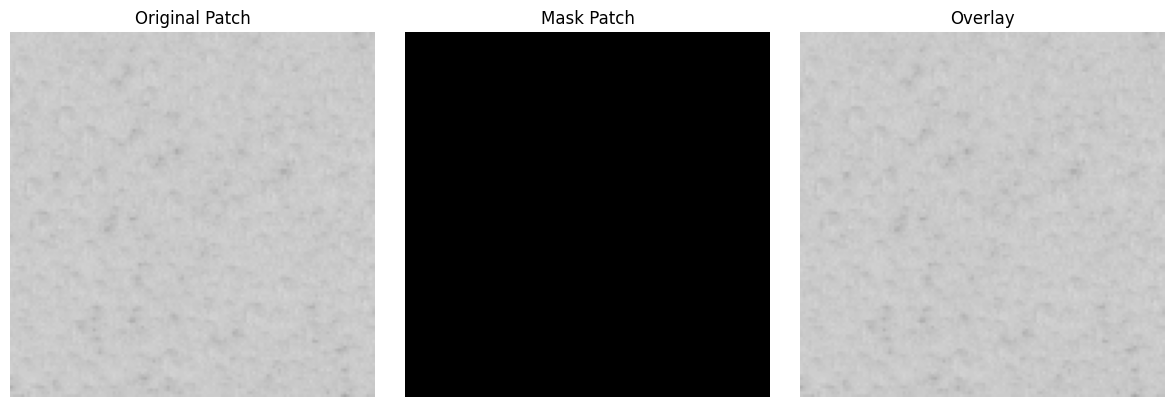

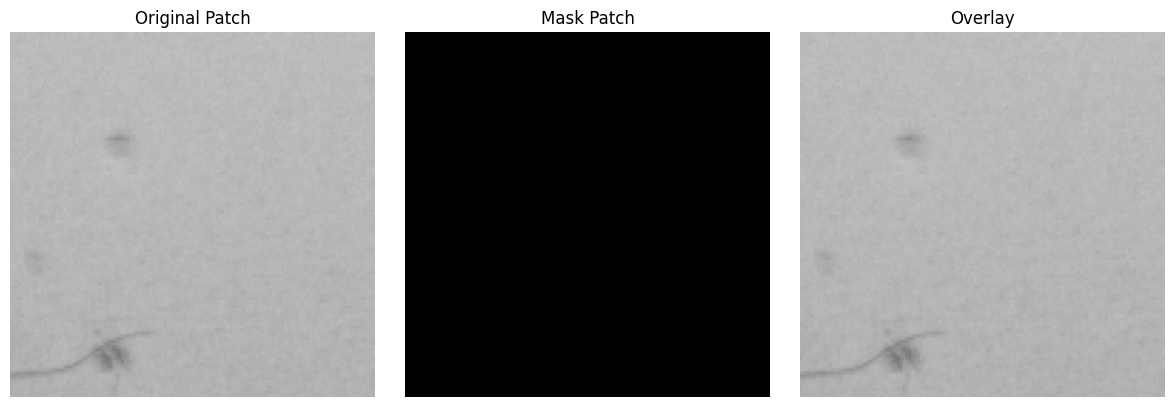

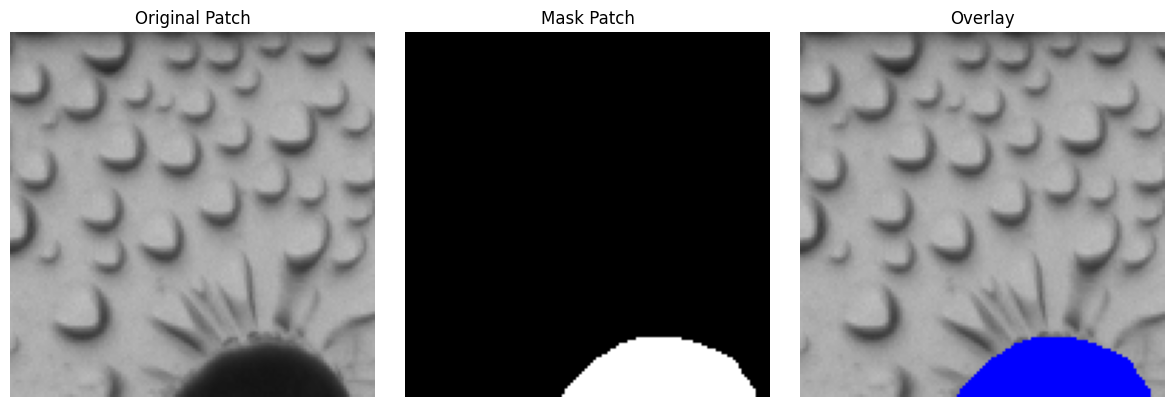

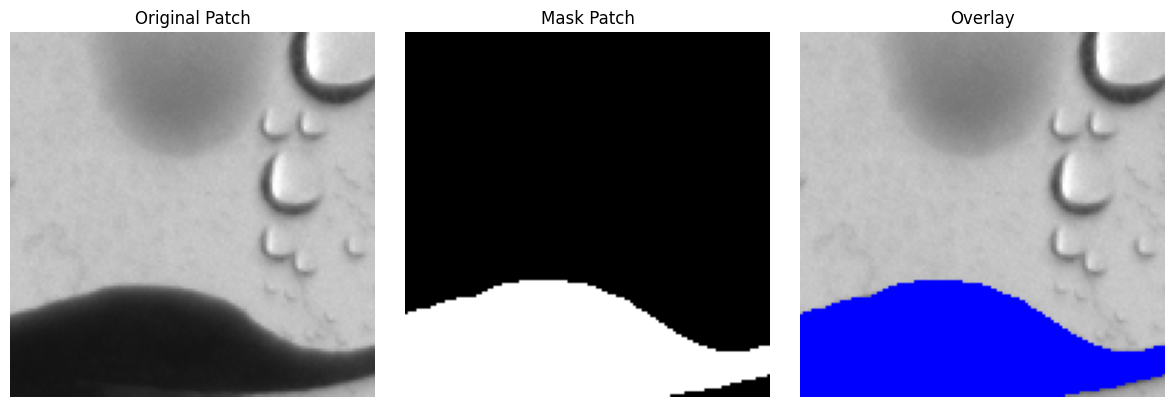

In [18]:
# Display random patches for verification
for _ in range(5):
    display_random_patch(OUTPUT_DIR, dataset_type="train")

## Part 3: Sanity Checks
This part ensures the integrity of the dataset by checking alignment, patch sizes, and pixel value ranges.

In [21]:
# Check patch size and alignment
train_image_dir = os.path.join(OUTPUT_DIR, "train_images", "train")
train_mask_dir = os.path.join(OUTPUT_DIR, "train_masks", "train")

In [22]:
for i, image_name in enumerate(os.listdir(train_image_dir)):
    if i == 20:  # Check first 20 images
        break
    image_path = os.path.join(train_image_dir, image_name)
    mask_path = os.path.join(train_mask_dir, image_name)

    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    assert image.shape[:2] == mask.shape, f"Mismatch in patch dimensions for {image_name}"
    assert image.shape[:2] == (PATCH_SIZE, PATCH_SIZE), f"Incorrect patch size for {image_name}"
    assert np.min(image) >= 0 and np.max(image) <= 255, f"Pixel values out of range in {image_name}"
    assert np.min(mask) >= 0 and np.max(mask) <= 255, f"Mask pixel values out of range in {image_name}"

In [23]:
print("Sanity checks passed: All patches are correctly aligned and sized.")

Sanity checks passed: All patches are correctly aligned and sized.
